# Pandas Case Study - Police Activity in RI

In [1]:
import sys
import datetime as dt

In [2]:
# Notebook Info
nb_info = {'Author':'Simon Zahn', 'Last Updated':dt.datetime.now().strftime('%Y-%m-%d %H:%M'), 'Python Version':sys.version }

for k,v in nb_info.items():
    print((k + ':').ljust(18), str(v))

Author:            Simon Zahn
Last Updated:      2019-08-10 18:46
Python Version:    3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]


--------------------------

### Table of Contents

1. [Imports and Top Matter](#Imports-and-Top-Matter)
1. [Preparing the Data for Analysis](#Preparing-the-Data-for-Analysis)
1. [Exploring the Relationship between Gender and Policing](#Exploring-the-Relationship-between-Gender-and-Policing)
1. [Visual Exploratory Data Analysis](#Visual-Exploratory-Data-Analysis)
1. [Analyzing the Effect of Weather on Policing](#Analyzing-the-Effect-of-Weather-on-Policing)
--------------------------

### Imports and Top Matter
[[back to top]](#Table-of-Contents)

In [96]:
# standard library
import itertools
import functools

# general

# IPython
from IPython.display import display, Image

# analysis
import numpy as np
import pandas as pd
from scipy import stats, special

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [97]:
pal = sns.color_palette()

### Preparing the Data for Analysis
[[back to top]](#Table-of-Contents)

Before beginning our analysis, we'll familiarize ourselves with the dataset.

In [25]:
# Read 'police.csv' into a DataFrame named ri
ri = pd.read_csv('data/police.csv')

# Examine the head of the DataFrame
display(ri.head())

# Count the number of missing values in each column
display(ri.info())

,state,stop_date,stop_time,county_name,driver_gender,driver_race,violation_raw,violation,search_conducted,search_type,stop_outcome,is_arrested,stop_duration,drugs_related_stop,district
0,RI,2005-01-04,12:55,NaN,M,White,Equipment/Inspection Violation,Equipment,False,NaN,Citation,False,0-15 Min,False,Zone X4
1,RI,2005-01-23,23:15,NaN,M,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone K3
2,RI,2005-02-17,04:15,NaN,M,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone X4
3,RI,2005-02-20,17:15,NaN,M,White,Call for Service,Other,False,NaN,Arrest Driver,True,16-30 Min,False,Zone X1
4,RI,2005-02-24,01:20,NaN,F,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone X3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91741 entries, 0 to 91740
Data columns (total 15 columns):
state                 91741 non-null object
stop_date             91741 non-null object
stop_time             91741 non-null object
county_name           0 non-null float64
driver_gender         86536 non-null object
driver_race           86539 non-null object
violation_raw         86539 non-null object
violation             86539 non-null object
search_conducted      91741 non-null bool
search_type           3307 non-null object
stop_outcome          86539 non-null object
is_arrested           86539 non-null object
stop_duration         86539 non-null object
drugs_related_stop    91741 non-null bool
district              91741 non-null object
dtypes: bool(2), float64(1), object(12)
memory usage: 9.3+ MB


None

In [26]:
# Drop the 'county_name' (all null) and 'state' columns (only RI)
ri.drop(['county_name', 'state'], axis='columns', inplace=True)

# Drop all rows that are missing 'driver_gender', since that'll be a focus of our analysis
ri.dropna(subset=['driver_gender'], inplace=True)

# Check and convert data types
ri['is_arrested'] = ri.is_arrested.astype(bool)

# Concatenate 'stop_date' and 'stop_time' (separated by a space) and convert to datetime format
ri['stop_datetime'] = pd.to_datetime( ri.stop_date.str.cat(ri.stop_time, sep=' ') )

# Set 'stop_datetime' as the index
ri.set_index('stop_datetime', inplace=True)

In [28]:
ri.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 86536 entries, 2005-01-04 12:55:00 to 2015-12-31 22:47:00
Data columns (total 13 columns):
stop_date             86536 non-null object
stop_time             86536 non-null object
driver_gender         86536 non-null object
driver_race           86536 non-null object
violation_raw         86536 non-null object
violation             86536 non-null object
search_conducted      86536 non-null bool
search_type           3307 non-null object
stop_outcome          86536 non-null object
is_arrested           86536 non-null bool
stop_duration         86536 non-null object
drugs_related_stop    86536 non-null bool
district              86536 non-null object
dtypes: bool(3), object(10)
memory usage: 7.5+ MB


### Exploring the Relationship between Gender and Policing
[[back to top]](#Table-of-Contents)

Before comparing the violations being committed by each gender, we should examine the violations committed by all drivers to get a baseline understanding of the data.

In [48]:
# Count the unique values in 'violation', # Express the counts as proportions
pd.concat([ri.violation.value_counts(),
           ri.violation.value_counts(normalize=True)], axis=1
         ).set_axis(['Violation Counts', 'Violation %'], axis=1, inplace=False)

,Violation Counts,Violation %
Speeding,48423,0.559571
Moving violation,16224,0.187483
Equipment,10921,0.126202
Other,4409,0.050950
Registration/plates,3703,0.042791
Seat belt,2856,0.033004


Now, let's check whether male and female drivers tend to commit different types of traffic violations.

In [54]:
# Compute the proportion of violations by each gender
pd.concat([ri[ri['driver_gender']=='F'].violation.value_counts(normalize=True),  # Female driver violations
           ri[ri['driver_gender']=='M'].violation.value_counts(normalize=True)], # Male driver violations
          axis=1, sort=False
         ).set_axis(['Female Violations', 'Male Violations'], axis=1, inplace=False)

,Female Violations,Male Violations
Speeding,0.658114,0.522243
Moving violation,0.138218,0.206144
Equipment,0.105199,0.134158
Registration/plates,0.044418,0.042175
Other,0.029738,0.058985
Seat belt,0.024312,0.036296


About $2/3$ of female traffic stops are for speeding, whereas stops of males are more balanced among the six categories. This doesn't mean that females speed more often than males, however, since we didn't take into account the number of stops or drivers.

When a driver is pulled over for speeding, many people believe that gender has an impact on whether the driver will receive a ticket or a warning. Can we find evidence of this in the dataset? We can use the `stop_outcome` column to calculate what percentage of stops resulted in a "Citation" (meaning a ticket) versus a "Warning".

In [58]:
pd.concat([ri[(ri.driver_gender == 'F') & (ri.violation == 'Speeding')].stop_outcome.value_counts(normalize=True),  # Female speeding stops
           ri[(ri.driver_gender == 'M') & (ri.violation == 'Speeding')].stop_outcome.value_counts(normalize=True)], # Male speeding stops
          axis=1, sort=False
         ).set_axis(['Female Speeding Violations', 'Male Speeding Violations'], axis=1, inplace=False)

,Female Speeding Violations,Male Speeding Violations
Citation,0.952192,0.944595
Warning,0.040074,0.036184
Arrest Driver,0.005752,0.015895
N/D,0.000959,0.000976
Arrest Passenger,0.000639,0.001281
No Action,0.000383,0.001068


Interesting! The numbers are similar for males and females: about 95% of stops for speeding result in a ticket. Thus, the data fails to show that gender has an impact on who gets a ticket for speeding.

During a traffic stop, the police officer sometimes conducts a search of the vehicle. Let's calculate the percentage of all stops that result in a vehicle search, also known as the search rate.

In [65]:
# Check the data type of 'search_conducted'
print(ri.search_conducted.dtype)

# Calculate the search rate by counting the values
print(ri.search_conducted.value_counts(normalize=True), end='\n\n')

# Calculate the search rate by taking the mean
print("Search Rate: {:.5f}".format(ri.search_conducted.mean()))

bool
False    0.961785
True     0.038215
Name: search_conducted, dtype: float64

Search Rate: 0.03822


It looks like the overall search rate is about 3.8%.  Now, we'll compare the rates at which female and male drivers are searched during a traffic stop.

In [66]:
# Calculate the search rate for both groups simultaneously
print(ri.groupby(by='driver_gender').search_conducted.mean())

driver_gender
F    0.019181
M    0.045426
Name: search_conducted, dtype: float64


Wow! Male drivers are searched more than twice as often as female drivers. Why might this be?

In [70]:
ri.pivot_table(values='search_conducted', index='violation', columns='driver_gender', aggfunc=np.mean)

driver_gender,F,M
violation,,
Equipment,0.039984,0.071496
Moving violation,0.039257,0.061524
Other,0.041018,0.046191
Registration/plates,0.054924,0.108802
Seat belt,0.017301,0.035119
Speeding,0.008309,0.027885


It looks like for all types of violations, the search rate is higher for males than for females.

During a vehicle search, the police officer may pat down the driver to check if they have a weapon. This is known as a "protective frisk." Let's first check to see how many times "Protective Frisk" was the only search type. Then, you'll use a string method to locate all instances in which the driver was frisked.

In [72]:
# Count the 'search_type' values
print(ri.search_type.value_counts())

# Check if 'search_type' contains the string 'Protective Frisk'
ri['frisk'] = ri.search_type.str.contains('Protective Frisk', na=False)

# Take the sum of 'frisk'
print()
print('Number of Protective Frisks: {}'.format(ri.frisk.sum()))

Incident to Arrest                                          1290
Probable Cause                                               924
Inventory                                                    219
Reasonable Suspicion                                         214
Protective Frisk                                             164
Incident to Arrest,Inventory                                 123
Incident to Arrest,Probable Cause                            100
Probable Cause,Reasonable Suspicion                           54
Incident to Arrest,Inventory,Probable Cause                   35
Probable Cause,Protective Frisk                               35
Incident to Arrest,Protective Frisk                           33
Inventory,Probable Cause                                      25
Protective Frisk,Reasonable Suspicion                         19
Incident to Arrest,Inventory,Protective Frisk                 18
Incident to Arrest,Probable Cause,Protective Frisk            13
Inventory,Protective Fris

What about the rates at which female and male drivers are frisked during a search? Are males frisked more often than females, perhaps because police officers consider them to be higher risk?

In [78]:
# Calculate the overall frisk rate by taking the mean of 'frisk'
print('Overall frisk rate: {}'.format(ri[ri['search_conducted']==True]['frisk'].mean()), end='\n\n')

# Calculate the frisk rate for each gender
print(ri[ri['search_conducted']==True].groupby(by='driver_gender')['frisk'].mean())

Overall frisk rate: 0.09162382824312065

driver_gender
F    0.074561
M    0.094353
Name: frisk, dtype: float64


### Visual Exploratory Data Analysis
[[back to top]](#Table-of-Contents)

When a police officer stops a driver, a small percentage of those stops ends in an arrest. This is known as the arrest rate. We'll find out whether the arrest rate varies by time of day. First, let's calculate the arrest rate across all stops. Then, we'll calculate the hourly arrest rate by using the hour attribute of the index. The hour ranges from 0 to 23, in which:

0 = midnight<br>
12 = noon<br>
23 = 11 PM

In [81]:
# Calculate the overall arrest rate
print('Overall arrest rate: {}'.format(ri['is_arrested'].mean()), end='\n\n')

# Save the hourly arrest rate
hourly_arrest_rate = ri.groupby(ri.index.hour).is_arrested.mean()
print(hourly_arrest_rate)

Overall arrest rate: 0.0355690117407784

stop_datetime
0     0.051431
1     0.064932
2     0.060798
3     0.060549
4     0.048000
5     0.042781
6     0.013813
7     0.013032
8     0.021854
9     0.025206
10    0.028213
11    0.028897
12    0.037399
13    0.030776
14    0.030605
15    0.030679
16    0.035281
17    0.040619
18    0.038204
19    0.032245
20    0.038107
21    0.064541
22    0.048666
23    0.047592
Name: is_arrested, dtype: float64


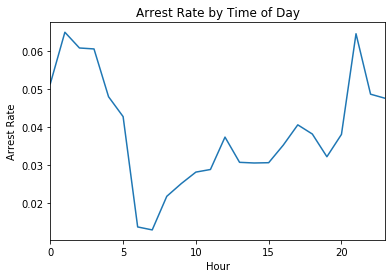

In [83]:
# Create a line plot of 'hourly_arrest_rate'
hourly_arrest_rate.plot()

# Add the xlabel, ylabel, and title
plt.xlabel('Hour')
plt.ylabel('Arrest Rate')
plt.title('Arrest Rate by Time of Day');

In a small portion of traffic stops, drugs are found in the vehicle during a search. Are these drug-related stops are becoming more common over time? The Boolean column `drugs_related_stop` indicates whether drugs were found during a given stop. We'll calculate the annual drug rate by resampling this column, and then we'll use a line plot to visualize how the rate has changed over time.

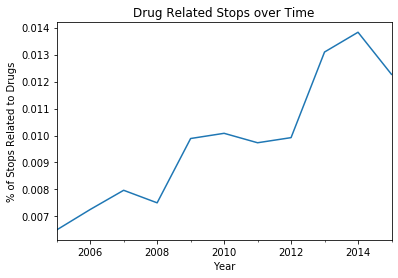

In [87]:
annual_drug_rate = ri.drugs_related_stop.resample('A').mean()
annual_drug_rate.plot()

plt.xlabel('Year')
plt.ylabel('% of Stops Related to Drugs')
plt.title('Drug Related Stops over Time');

The rate of drug-related stops nearly doubled over the course of 10 years. Why might that be the case?

We might hypothesize that the rate of vehicle searches was also increasing, which would have led to an increase in drug-related stops even if more drivers were not carrying drugs. Let's test this hypothesis by calculating the annual search rate, and then plotting it against the annual drug rate. If the hypothesis is true, then we'll see both rates increasing over time.

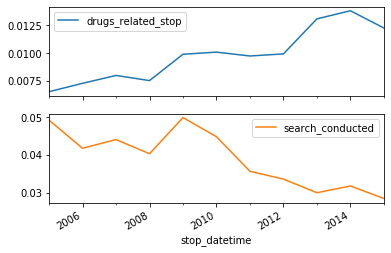

In [89]:
# Calculate and save the annual search rate
annual_search_rate = ri.search_conducted.resample('A').mean()

# Concatenate 'annual_drug_rate' and 'annual_search_rate'
annual = pd.concat([annual_drug_rate, annual_search_rate], axis='columns')

# Create subplots from 'annual'
annual.plot(subplots=True);

Wow! The rate of drug-related stops increased even though the search rate decreased, disproving our hypothesis.

The state of Rhode Island is broken into six police districts, also known as zones. How do the zones compare in terms of what violations are caught by police? We'll create a frequency table to determine how many violations of each type took place in each of the six zones. Then, we'll filter the table to focus on the "K" zones.

In [92]:
# Create a frequency table of districts and violations
display(pd.crosstab(ri['district'], ri['violation']))

# Save the frequency table as 'all_zones'
all_zones = pd.crosstab(ri['district'], ri['violation'])

# Select rows 'Zone K1' through 'Zone K3' and save the smaller table as 'k_zones'
k_zones = all_zones.loc['Zone K1':'Zone K3']

violation,Equipment,Moving violation,Other,Registration/plates,Seat belt,Speeding
district,,,,,,
Zone K1,672,1254,290,120,0,5960
Zone K2,2061,2962,942,768,481,10448
Zone K3,2302,2898,705,695,638,12322
Zone X1,296,671,143,38,74,1119
Zone X3,2049,3086,769,671,820,8779
Zone X4,3541,5353,1560,1411,843,9795


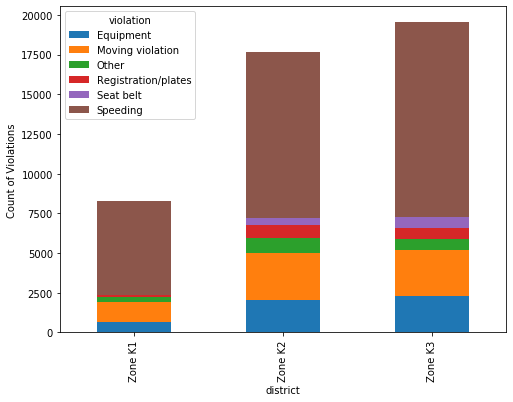

In [99]:
# Create a stacked bar plot of 'k_zones'
k_zones.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.ylabel('Count of Violations');

Interesting! The vast majority of traffic stops in Zone K1 are for speeding, and Zones K2 and K3 are remarkably similar to one another in terms of violations.

In the traffic stops dataset, the `stop_duration` column tells us approximately how long the driver was detained by the officer. Unfortunately, the durations are stored as strings, such as '0-15 Min'. Let's convert the stop durations to integers. Because the precise durations are not available, we'll have to estimate the numbers using reasonable values:

Convert '0-15 Min' to 8<br>
Convert '16-30 Min' to 23<br>
Convert '30+ Min' to 45

In [102]:
# Print the unique values in 'stop_duration'
print('Original stop_duration values: ', ri.stop_duration.unique())

# Create a dictionary that maps strings to integers
mapping = {'0-15 Min':8, '16-30 Min':23, '30+ Min':45}

# Convert the 'stop_duration' strings to integers using the 'mapping'
ri['stop_minutes'] = ri.stop_duration.map(mapping)

# Print the unique values in 'stop_minutes'
print('Mapped stop_duration values: ', ri.stop_minutes.unique())

Original stop_duration values:  ['0-15 Min' '16-30 Min' '30+ Min']
Mapped stop_duration values:  [ 8 23 45]


If you were stopped for a particular violation, how long might you expect to be detained? Let's visualize the average length of time drivers are stopped for each type of violation. Rather than using the `violation` column, we'll use `violation_raw` since it contains more detailed descriptions of the violations.

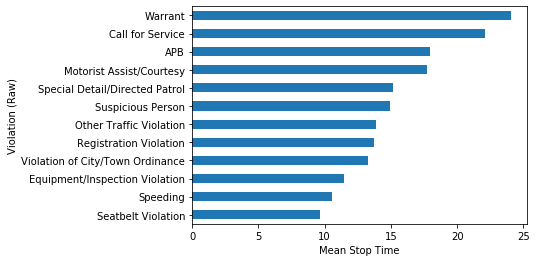

In [109]:
ri.groupby(by='violation_raw')['stop_minutes'].mean().sort_values().plot(kind='barh')
plt.ylabel('Violation (Raw)')
plt.xlabel('Mean Stop Time');

### Analyzing the Effect of Weather on Policing
[[back to top]](#Table-of-Contents)

We'll start by examining the temperature columns from the weather dataset to assess whether the data seems trustworthy. First let's print the summary statistics, and then we'll visualize the data using a box plot. When deciding whether the values seem reasonable, keep in mind that the temperature is measured in degrees Fahrenheit, not Celsius!

,TMIN,TAVG,TMAX
count,4017.000000,1217.000000,4017.000000
mean,43.484441,52.493016,61.268608
std,17.020298,17.830714,18.199517
min,-5.000000,6.000000,15.000000
25%,30.000000,39.000000,47.000000
50%,44.000000,54.000000,62.000000
75%,58.000000,68.000000,77.000000
max,77.000000,86.000000,102.000000


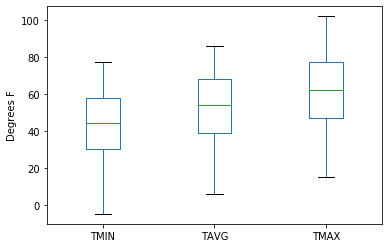

In [113]:
# Read 'weather.csv' into a DataFrame named 'weather'
weather = pd.read_csv('data/weather.csv')

# Describe the temperature columns
display(weather[['TMIN', 'TAVG', 'TMAX']].describe())

# Create a box plot of the temperature columns
weather[['TMIN', 'TAVG', 'TMAX']].plot(kind='box')
plt.ylabel('Degrees F');

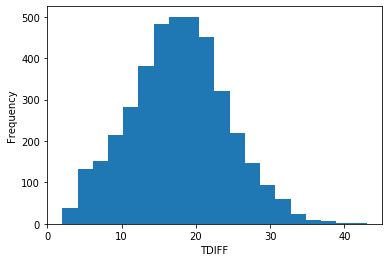

In [115]:
# Create a 'TDIFF' column that represents temperature difference
weather['TDIFF'] = weather['TMAX'] - weather['TMIN']

# Create a histogram with 20 bins to visualize 'TDIFF'
weather.TDIFF.plot(kind='hist', bins=20)
plt.xlabel('TDIFF');

The `TDIFF` column has no negative values and its distribution is approximately normal, both of which are signs that the data is trustworthy.

The weather DataFrame contains 20 columns that start with 'WT', each of which represents a bad weather condition. For example:

WT05 indicates "Hail"
WT11 indicates "High or damaging winds"
WT17 indicates "Freezing rain"
For every row in the dataset, each WT column contains either a 1 (meaning the condition was present that day) or NaN (meaning the condition was not present).

Let's quantify "how bad" the weather was each day by counting the number of 1 values in each row.

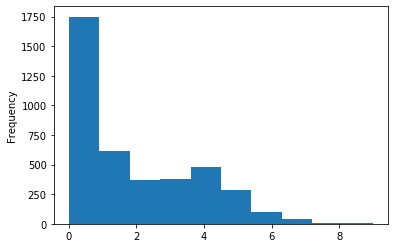

In [120]:
# Calculate the sum of each row for 'WTX'
weather['bad_conditions'] = weather.loc[:, 'WT01':'WT22'].sum(axis=1)

# Replace missing values in 'bad_conditions' with '0'
weather['bad_conditions'] = weather.bad_conditions.fillna(0).astype('int')

# Create a histogram to visualize 'bad_conditions'
weather['bad_conditions'].plot(kind='hist')

Now we can use the counts to create a rating system for the weather. The counts range from 0 to 9, and should be converted to ratings as follows:

Convert 0 to 'good'<br>
Convert 1 through 4 to 'bad'<br>
Convert 5 through 9 to 'worse'

In [121]:
# Create a dictionary that maps integers to strings
mapping = {0:'good', 1:'bad', 2:'bad', 3:'bad', 4:'bad', 5:'worse', 6:'worse', 7:'worse', 8:'worse', 9:'worse'}

# Convert the 'bad_conditions' integers to strings using the 'mapping'
weather['rating'] = weather.bad_conditions.map(mapping)

# Count the unique values in 'rating'
print(weather['rating'].value_counts())

bad      1836
good     1749
worse     432
Name: rating, dtype: int64


Since the rating column only has a few possible values, we'll change its data type to category in order to store the data more efficiently. We'll also specify a logical order for the categories, which will be useful in the future.

In [123]:
# Create a list of weather ratings in logical order
weather_cat_dtype = pd.api.types.CategoricalDtype(categories=['good', 'bad', 'worse'], ordered=True)

# Change the data type of 'rating' to category
weather['rating'] = weather.rating.astype(weather_cat_dtype)

# Examine the head of 'rating'
print(weather.rating.head())

0    bad
1    bad
2    bad
3    bad
4    bad
Name: rating, dtype: category
Categories (3, object): [good < bad < worse]


Now, we'll prepare the traffic stop and weather rating DataFrames so that they're ready to be merged:

With the `ri` DataFrame, we'll move the `stop_datetime` index to a column since the index will be lost during the merge. With the `weather` DataFrame, we'll select the `DATE` and `rating` columns and put them in a new DataFrame.

Then, we'll merge the `ri` and `weather_rating` DataFrames into a new DataFrame, `ri_weather`. The DataFrames will be joined using the `stop_date` column from `ri` and the `DATE` column from `weather_rating`. Thankfully the date formatting matches exactly, which is not always the case! Once the merge is complete, we'll set stop_datetime as the index.

In [124]:
# Reset the index of 'ri'
ri.reset_index(inplace=True)

# Create a DataFrame from the 'DATE' and 'rating' columns
weather_rating = weather.loc[:, ['DATE', 'rating']]

In [125]:
# Merge 'ri' and 'weather_rating' using a left join
ri_weather = pd.merge(left=ri, right=weather_rating, left_on='stop_date', right_on='DATE', how='left')

# Set 'stop_datetime' as the index of 'ri_weather'
ri_weather.set_index('stop_datetime', inplace=True)

Now we can use `ri_weather` to analyze the relationship between weather conditions and police behavior.

Do police officers arrest drivers more often when the weather is bad? Let's find out! 

First, we'll calculate the overall arrest rate. Then, we'll calculate the arrest rate for each of the weather ratings we previously assigned. Finally, we'll add violation type as a second factor in the analysis, to see if that accounts for any differences in the arrest rate. Since we previously defined a logical order for the weather categories, good < bad < worse, they will be sorted that way in the results.

In [127]:
# Calculate the arrest rate for each 'rating'
print(ri_weather.groupby(by='rating').is_arrested.mean(), end='\n\n\n')

# Calculate the arrest rate for each 'violation' and 'rating'
print(ri_weather.groupby(by=['violation', 'rating']).is_arrested.mean())

rating
good     0.033715
bad      0.036261
worse    0.041667
Name: is_arrested, dtype: float64


violation            rating
Equipment            good      0.059007
                     bad       0.066311
                     worse     0.097357
Moving violation     good      0.056227
                     bad       0.058050
                     worse     0.065860
Other                good      0.076966
                     bad       0.087443
                     worse     0.062893
Registration/plates  good      0.081574
                     bad       0.098160
                     worse     0.115625
Seat belt            good      0.028587
                     bad       0.022493
                     worse     0.000000
Speeding             good      0.013405
                     bad       0.013314
                     worse     0.016886
Name: is_arrested, dtype: float64


Interesting! The arrest rate increases as the weather gets worse, and that trend persists across many of the violation types. This doesn't prove a causal link, but it's quite an interesting result!